Solutions Sheet 1.1: Vanilla RSA
================================

**Author:** Michael Franke



Imports:



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Context model:



In [1]:
##################################################
## defining the context
##################################################

object_names    = ['blue_circle', 'green_square', 'blue_square']
utterance_names = ['blue', 'circle', 'green', 'square']

semantic_meaning = np.array(
    # blue circle, green square, blue square
    [[1, 0, 1],  # blue
     [1, 0, 0],  # circle
     [0, 1, 0],  # green
     [0, 1, 1]]  # square,
    )

Helper functions:



In [1]:
##################################################
## helper functions
##################################################

def softmax(x, axis=1):
    """
    Softmax function in numpy
    Parameters
    ----------
    x: array
        An array with any dimensionality
    axis: int
        The axis along which to apply the softmax
    Returns
    -------
    array
        Same shape as x
    """
    e_x = np.exp(x - np.max(x, axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.1: Apply the helper functions</span></strong>
> 1. Normalize the following matrix to a row-stochastic and a column-stochastic matrix for the matrix: $[[1,2], [3,4]]$.
> 2. Apply softmax to the following matrix to obtain a row-stochastic and a column-stochastic matrix:  $[[1,2], [3,4], [5,6]]$.
> 3. Compute the soft-max and the normalized stochastic vector for the vector $[1,2,3]$. (NB: the definitions do *not* expect vector input, so &#x2026; what do you do?)



In [1]:
##################################################
## solutions here for exercise 1.1.1
##################################################

# 1.
print("Part 1")
m1 = np.array([[1,2], [3,4]])
print("starting point:\n", m1)
print("row-stochastic:\n", normalize(m1,1))
print("col-stochastic:\n", normalize(m1,0))

# 2.
print("\nPart 2")
m2 = np.array([[1,2], [3,4], [5,6]])
print("starting point:\n", m2)
print("row-stochastic:\n", softmax(m2,1))
print("col-stochastic:\n", softmax(m2,0))

# 3.

print("\nPart 3")
v = np.array([1,2,3])
print("starting point:\n", v)
print("softmax:\n", softmax(np.array([v]),1)[0])
print("normalize:\n", normalize(np.array([v]),1)[0])

#+begin_example
Part 1
starting point:
 [[1 2]
 [3 4]]
row-stochastic:
 [[0.33333333 0.66666667]
 [0.42857143 0.57142857]]
col-stochastic:
 [[0.25       0.33333333]
 [0.75       0.66666667]]

Part 2
starting point:
 [[1 2]
 [3 4]
 [5 6]]
row-stochastic:
 [[0.26894142 0.73105858]
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]]
col-stochastic:
 [[0.01587624 0.01587624]
 [0.11731043 0.11731043]
 [0.86681333 0.86681333]]

Part 3
starting point:
 [1 2 3]
softmax:
 [0.09003057 0.24472847 0.66524096]
normalize:
 [0.16666667 0.33333333 0.5       ]
#+end_example

The model we want to implement is defined as follows:

\begin{align*}
P_{lit}(s \mid u) & \propto L(u,s) \\
P_S( u \mid s) &= \mathrm{SoftMax}  \left ( \alpha \left ( \log P_{lit}(s \mid u)  - \mathrm{C}(u) \right ) \right ) \\
P_L( s \mid u) & \propto P_{sal}(s) \ P_S( u \mid s)
\end{align*}

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.2: Paraphrase the definitions</span></strong>
>
> Provide a short, intuitive and explanatory paraphrase for each of the three conditional probability distributions that define the RSA model above. I.e., formulate a sentence or two for each, so that a person can understand the purpose or gist of the definition. The less technical jargon you use, the better. The more insightful to a novice, the better.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Solutions for Exercise 1.1.2</span></strong>
>
> The literal listener is a conditional probability, where the probability of a state $s$ given an utterance $u$ is proportional to the truth-value of $u$ in $s$. This means that the literal listener assigns equal probability to each state in which $u$ is true.
>
> The speaker assigns a probability to each utterance proportionally to how good that utterance is. Goodness is defined in terms of informativity and a cost term.
>
> The pragmatic speaker is defined in terms of Bayes rule, based on a salience prior over states and the speaker&rsquo;s production protocol as a likelihood function.

Implementation:



blue  circle  green  square        object
blue_circle   0.31    0.69   0.00    0.00   blue_circle
green_square  0.00    0.00   0.64    0.36  green_square
blue_square   0.48    0.00   0.00    0.52   blue_square
        blue_circle  green_square  blue_square utterance
blue            0.4           0.0          0.6      blue
circle          1.0           0.0          0.0    circle
green           0.0           1.0          0.0     green
square          0.0           0.4          0.6    square

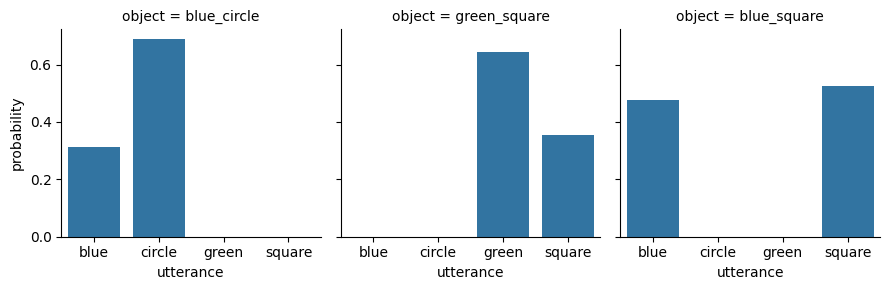

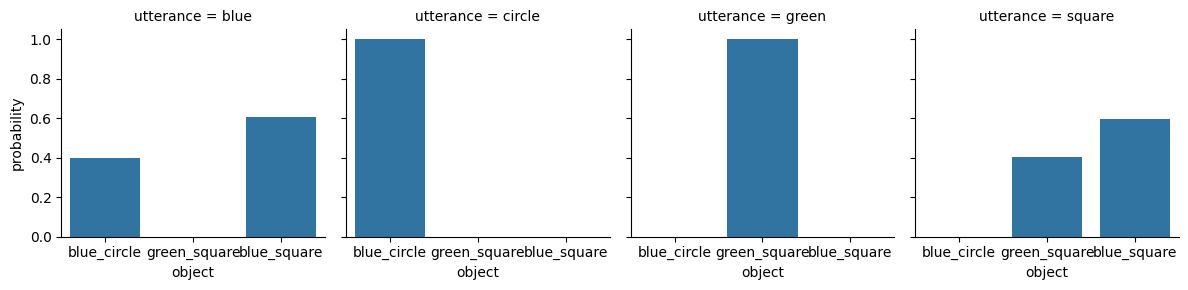

In [1]:
##################################################
## model parameters
##################################################

alpha              = 1
cost_adjectives    = 0.1
salience_prior_flt = np.array([1,1,1])     # flat
salience_prior_emp = np.array([71,139,30]) # empirical

##################################################
## RSA model predictions
##################################################


def RSA(alpha, cost_adjectives, salience_prior):
    """
    predictions of the vanilla RSA model for reference game
    Parameters
    ----------
    alpha: float
        Optimality parameter
    cost_adjectives: float
        Differential cost for production of adjectives
    salience_prior: array
        Prior over objects
    Returns
    -------
    dictionary
        Dictionary with keys 'speaker' and 'listener'
    """
    costs              = np.array([1.0, 0, 1.0, 0]) * cost_adjectives
    literal_listener   = normalize(semantic_meaning)
    util_speaker       = np.log(np.transpose(literal_listener)) - costs
    pragmatic_speaker  = softmax(alpha * util_speaker)
    pragmatic_listener = normalize(np.transpose(pragmatic_speaker) * salience_prior)
    return({'speaker': pragmatic_speaker, 'listener': pragmatic_listener})

RSA_predictions = RSA(alpha, cost_adjectives, salience_prior_flt)

##################################################
## cast model predictions to DataFrames
##################################################

speaker  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
speaker['object'] = speaker.index
print(speaker.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
listener['utterance'] = listener.index
print(listener.round(2))

##################################################
## plotting the results
##################################################

speaker_long = speaker.melt(id_vars = "object", var_name = "utterance",
                            value_name = "probability", ignore_index = False)
speaker_plot = sns.FacetGrid(speaker_long, col="object")
speaker_plot.map(sns.barplot, "utterance", "probability")
plt.show()

listener_long = listener.melt(id_vars = "utterance", var_name = "object",
                              value_name = "probability", ignore_index = False)
listener_plot = sns.FacetGrid(listener_long, col="utterance")
listener_plot.map(sns.barplot, "object", "probability")
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.3: Explore the vanilla RSA model</span></strong>
>
> 0. [for your own sake only; no written answer required] Go through the whole last code block. Try to understand every single line in the function \`RSA<sub>predictions</sub>\`. Ask if anything is unclear. (It is muss less important to understand the details of the subsequent data wrangling and plotting.)
> 1. Explore what happens if you make the speaker more optimal. Does that also affect the listener&rsquo;s inferences? Why? Is that intuitive?
> 2. Add another object to the context, namely a red triangle. Add any relevant utterances, their semantics and costs as well. What do you predict will happen to the model&rsquo;s predictions for the &ldquo;old&rdquo; objects and utterances? Test your predictions (= understanding of the model) and report the results.
> 3. Run the model with different values for the cost parameter \`cost<sub>adjectives</sub>\`. Which effect does this have on the speaker prediction? Which effect does that have on the predictions for listener interpretation? Explain these observations in your own non-technical terms (e.g., for an interested outsider).
> 4. Is there any way to get “blue” to refer to something green? I.e., is it possible (if so: how?; else: why not?) to change the context or model in such a way that $P_{L}(\text{green square} \mid \text{blue}) > 0$, ideally in a way that might also be defensible in that it makes conceptual sense (not just by some technical trick that no reviewer of your work would accept as anything but a hack)?

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Solutions for Exercise 1.1.3</span></strong>
>
> 1. Making the speaker more optimal is achieved by increasing the value of $\alpha$. The higher $\alpha$, the more the speaker rule approximates a purely rational agent who always chooses the (or an) utterance that maximizes the utility score. As the listener is defined in terms of Bayes rule, with $P_{S}$ as a likelihood function, changes of $\alpha$ also affect the listener&rsquo;s interpretation. This is intuitive because my interpretation of an utterance almost certainly changes if my belief about the rationality (or idioticity) of the speaker changes.
>
> 2. We predict that adding a red triangle and words &rsquo;red&rsquo; and &rsquo;triangle&rsquo; will not change the predictions for the &ldquo;old part&rdquo; of the context model, because the new words will all be false of all the old objects.
> Adding another object gives us a new context model.
> The previous RSA function was (deliberately!?!) written in such a way that we cannot use it as-is for this amended context model. Let&rsquo;s fix this in a general way:



In [1]:
##################################################
## defining the context
##################################################

object_names    = ['blue_circle', 'green_square', 'blue_square', 'red triangle']
utterance_names = ['blue', 'circle', 'green', 'square', 'red', 'triangle']

semantic_meaning = np.array(
    # blue circle, green square, blue square, red triangle
    [[1, 0, 1, 0],  # blue
     [1, 0, 0, 0],  # circle
     [0, 1, 0, 0],  # green
     [0, 1, 1, 0],  # square
     [0, 0, 0, 1],  # red,
     [0, 0, 0, 1]]  # triangle
    )

cost_adjectives = 0.1

context_model = {
    'object_names'     : object_names,
    'utterance_names'  : utterance_names,
    'semantic_meaning' : semantic_meaning,
    'costs'            : np.array([1.0, 0, 1.0, 0, 1.0, 0]) * cost_adjectives,
    'salience_prior'   : np.array([1.0, 1.0, 10.0, 1.0]) / 4
}

def RSARev(alpha, context_model):
    """
    predictions of the vanilla RSA model for reference game
    Parameters
    ----------
    alpha: float
        Optimality parameter
    context_model: dict
        Objects & their salience, utterances & their meanings & costs
    Returns
    -------
    dictionary
        Dictionary with keys 'speaker' and 'listener'
    """
    costs              = context_model['costs']
    literal_listener   = normalize(context_model['semantic_meaning'])
    util_speaker       = np.log(np.transpose(literal_listener)) - costs
    pragmatic_speaker  = softmax(alpha * util_speaker)
    pragmatic_listener = normalize(np.transpose(pragmatic_speaker) *
                                   context_model['salience_prior'])
    return({'speaker': pragmatic_speaker, 'listener': pragmatic_listener})

RSA_predictions = RSARev(alpha, context_model)

##################################################
## cast model predictions to DataFrames
##################################################

speakerRev  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
print(speakerRev.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
print(listener.round(2))

#+begin_example
              blue  circle  green  square   red  triangle
blue_circle   0.31    0.69   0.00    0.00  0.00      0.00
green_square  0.00    0.00   0.64    0.36  0.00      0.00
blue_square   0.48    0.00   0.00    0.52  0.00      0.00
red triangle  0.00    0.00   0.00    0.00  0.48      0.52
          blue_circle  green_square  blue_square  red triangle
blue             0.06          0.00         0.94           0.0
circle           1.00          0.00         0.00           0.0
green            0.00          1.00         0.00           0.0
square           0.00          0.06         0.94           0.0
red              0.00          0.00         0.00           1.0
triangle         0.00          0.00         0.00           1.0
#+end_example

> 3. Increasing the cost parameter makes the speaker prefer nouns more strongly over adjectives. If we set it to negative values, the pattern is reversed. This parameter also affects the listener part. For example, if costs of adjectives are very high, the speaker will prefer to also choose &ldquo;square&rdquo; for the green square, thus overriding the pressure to be informative. As a result, when the listener hears &ldquo;square&rdquo; they will think that it is (roughly) equally likely that the speaker is referring to the &ldquo;green square&rdquo; or the &ldquo;blue square&rdquo;.
>
> 4. A simple way to achieve this result is to use what is sometimes called a &ldquo;soft-semantics&rdquo;, where truth values are not 0 or 1, but something close to these extremes. For example:



In [1]:
eps = 0.0001
semantic_meaning = np.array(
    # blue circle, green square, blue square
    [[1-eps, eps  , 1-eps]  ,  # blue
     [1-eps, eps  , eps]    ,  # circle
     [eps  , 1-eps, eps]    ,  # green
     [eps  , 1-eps, 1-eps]]  # square,
   )

> One way of making plausible such a semantics is by arguing that even if a single agent is absolutely rock-certain about black-and-white truth-values, they might not be as certain about the other person&rsquo;s infallible language use. (NB: the lecturer does not believe that this is a very good defense of this set up; just for the record.)

